# Risk Measures

This notebook illustrates the Value at Risk (VaR) and tests it on a data set. To improve the performance, a model for time-varying risk is estimated and incorporated into the VaR calculations.

We use the The [Distributions.jl](https://github.com/JuliaStats/Distributions.jl) package to calculate probability values and quantiles.

## Load Packages and Extra Functions

In [1]:
using Printf, Dates, Distributions, DelimitedFiles

include("jlFiles/printmat.jl")

printyellow (generic function with 1 method)

In [2]:
using Plots

#pyplot(size=(600,400))
gr(size=(480,320))
default(fmt = :svg)

# Value at Risk (VaR) for a N(μ,σ²) Return

$\textrm{VaR}_{95\%} = - (5^{th}$ percentile of the return distribution)

With a $N(\mu,\sigma^2)$ distribution this gives

$\textrm{VaR}_{95\%} = - (\mu-1.64\sigma)$

### A Remark on the Code
- The Distributions.jl package defines a normal distribution as `Normal(μ,σ)`. Notice that it uses the standard deviation, not the variance. For instance, to calculate the 5th quantile, use `quantile(Normal(μ,σ),0.05)` and to calculate the pdf value at each element of a vector `x`, use `pdf.(Normal(μ,σ),x)`.

In [3]:
μ = 8
σ = 16

q05   = μ - 1.64*σ 
VaR95 = -(μ - 1.64*σ)

printblue("with μ=$μ and σ=$σ, we have approximately:\n")
printmat([q05,VaR95],rowNames=["5th quantile","VaR 95%"])

with μ=8 and σ=16, we have approximately:

5th quantile   -18.240
VaR 95%         18.240



In [4]:
q05b = quantile(Normal(μ,σ),0.05)    #exact calculation of the the 5th quantile, notice: σ

printlnPs("get an exact result by using the quantile() function: ",q05b)

get an exact result by using the quantile() function:    -18.318


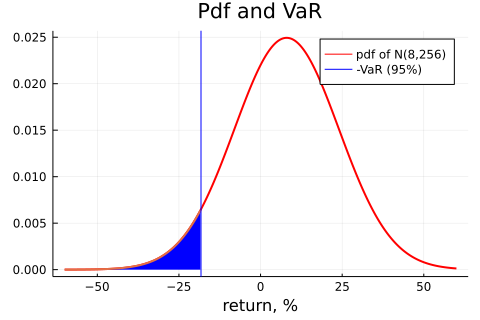

In [5]:
R    = range(-60,60,length=301)
pdfR = pdf.(Normal(μ,σ),R)
Rb   = R[R .<= -VaR95]             #or filter(<=(-VaR95),R)

p1 = plot( R,pdfR,
           linecolor = :red,
           linewidth = 2,
           label = "pdf of N($μ,$(σ^2))",
           title = "Pdf and VaR",
           xlabel = "return, %" )
plot!(Rb,pdf.(Normal(μ,σ),Rb),fillcolor=:red,linewidth=2,fill=(0,:blue),label="")
vline!([-VaR95],linecolor=:blue,label="-VaR (95%)")
display(p1)

# Loading Daily S&P 500 Data

In [6]:
x  = readdlm("Data/SP500RfPs.csv",',',skipstart=1)
SP = x[:,2]                               #S&P 500 level
R  = (SP[2:end]./SP[1:end-1] .- 1) * 100  #returns, % 
T  = length(R)

dN = Date.(x[2:end,1],"d/m/y");    #convert to Date, 2:end as for R

println("Days in the sample: $T")

Days in the sample: 9352


# Backtesting a Static VaR from N() on Data

To backtest a VaR model, study the relative frequency of Loss > VaR. 

The code below does this for difference confidence levels (0.95,0.96,...) of the VaR. For instance at the 0.95 confidence levels we
1. calculate the VaR as the (negative of the) 0.05 quantile of a normal distribution (with mean and std estimated from the sample)
2. count the relative frequency of the loss > VaR (it should be 0.05).

In [7]:
μ_emp = mean(R)                     #mean and std of data
σ_emp = std(R)

confLev = 0.95:0.005:0.995          #different confidence levels
L       = length(confLev)
Loss    = -R

(VaR,BreakFreq) = (fill(NaN,L),fill(NaN,L))
for i = 1:L                 #loop over confidence levels
    VaR[i]       = -quantile(Normal(μ_emp,σ_emp),1-confLev[i])
    BreakFreq[i] = mean(Loss .> VaR[i]) #freq of breaking the VaR
end

printblue("Backtesting a static VaR:\n")
colNames = ["conf level","N()-based VaR","break freq"]
printmat([confLev VaR BreakFreq],colNames=colNames,width=18)

printred("The break frequency should be 1-confidence level")

Backtesting a static VaR:

        conf level     N()-based VaR        break freq
             0.950             1.790             0.041
             0.955             1.846             0.037
             0.960             1.907             0.034
             0.965             1.975             0.032
             0.970             2.052             0.029
             0.975             2.140             0.026
             0.980             2.244             0.023
             0.985             2.373             0.019
             0.990             2.547             0.016
             0.995             2.824             0.012

The break frequency should be 1-confidence level


The code below also studies the relative frequency of Loss > VaR, but over a moving data window (and only for a single confidence level, 0.95). This allows us to investigate if there are long periods of failures of the VaR calculations.

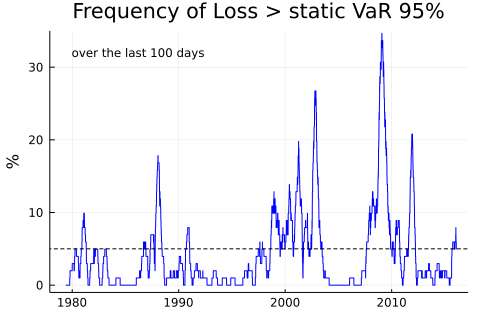

In [8]:
VaR95 = -(μ_emp - 1.64*σ_emp)

BreakFreqT = fill(NaN,T)                   #vector, freq(Loss>VaR) on moving data window
for t = 101:T
    BreakFreqT[t] = mean(Loss[t-100:t] .> VaR95)
end

xTicksLoc = [Date(1980);Date(1990);Date(2000);Date(2010)]
xTicksLab = Dates.format.(xTicksLoc,"Y")

p1 = plot( dN,BreakFreqT*100,
           linecolor = :blue,
           ylim = (-1,35),
           legend = false,
           xticks = (xTicksLoc,xTicksLab),
           title = "Frequency of Loss > static VaR 95%",
           ylabel = "%",
           annotation = (Date(1980),32,text("over the last 100 days",8,:left)) )
hline!([5],linecolor=:black,line=(:dash,1))
display(p1)

# A Simple Dynamic VaR with Time-Varying Volatility

We first construct an simple estimate of $\sigma_t^2$ as a backward looking exponential moving average

$\sigma_t^2 = \lambda \sigma_{t-1}^2 + (1-\lambda) (R_{t-1} -\mu_{t-1})^2$,
where $\mu_{t}=\lambda \mu_{t-1} + (1-\lambda) R_{t-1}$ 

We then redo the VaR$_{95\%}$ calculation using
$\textrm{VaR}_{t} = - (\mu_t-1.64\sigma_t)$ and study if it has better properties than the static VaR.

In [9]:
λ   = 0.94
(μT,s2T) = (fill(μ_emp,T),fill(σ_emp^2,T)) #vectors, time-varying mean and variance
for t = 2:T
    μT[t]  = λ*μT[t-1]  + (1-λ)*R[t-1]
    s2T[t] = λ*s2T[t-1] + (1-λ)*(R[t-1]-μT[t-1])^2    #RiskMetrics approach
end

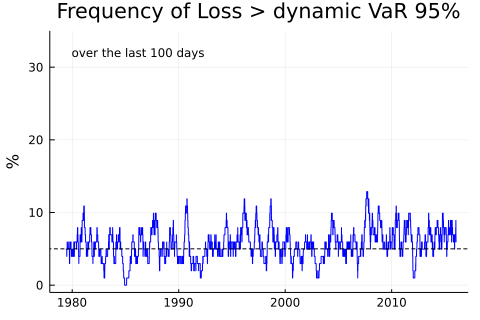

In [10]:
VaR95 = -(μT .- 1.64*sqrt.(s2T))

BreakFreqT = fill(NaN,T)         #freq(Loss>VaR) on moving data window
for t = 101:T
    BreakFreqT[t] = mean(Loss[t-100:t] .> VaR95[t-100:t])
end

xTicksLoc = [Date(1980);Date(1990);Date(2000);Date(2010)]
xTicksLab = Dates.format.(xTicksLoc,"Y")

p1 = plot( dN,BreakFreqT*100,
           linecolor = :blue,
           ylim = (-1,35),
           legend = false,
           xticks = (xTicksLoc,xTicksLab),
           title = "Frequency of Loss > dynamic VaR 95%",
           ylabel= "%",
           annotation = (Date(1980),32,text("over the last 100 days",8,:left)) )
hline!([5],linecolor=:black,line=(:dash,1))
display(p1)

# Expected Shortfall

Recall: $\text{ES}_{\alpha}=-\text{E}(R|R\leq-\text{VaR}_{\alpha})$

For a normally distributed return $R\sim N(\mu,\sigma^{2})$ we have

$\text{ES}_{95\%}=-\mu+\frac{\phi(-1.64)}{0.05}\sigma$,

where $\phi()$ is the pdf of a $N(0,1)$ variable. For other confidence levels, change -1.64 and 0.05.

In [11]:
μ = 8
σ = 16
ES95 = -μ + pdf(Normal(0,1),-1.64)/0.05*σ

printlnPs("N() based ES 95% with μ=$μ and σ=$σ is: ",ES95)

N() based ES 95% with μ=8 and σ=16 is:     25.268


In [12]:
(ESN,ES_emp) = (fill(NaN,L),fill(NaN,L)) 
for i = 1:L
    #local c, vv_i           #local/global is needed in script
    c         = quantile(Normal(0,1),1-confLev[i])  #critical value
    ESN[i]    = -μ_emp .+ pdf(Normal(0,1),c)/(1-confLev[i])*σ_emp
    vv_i      = Loss .> VaR[i]
    ES_emp[i] = mean(Loss[vv_i])        #mean of obs when Loss > VaR
end

printblue("Expected shortfall:\n")
colNames = ["conf level","ES from N()","ES (historical)"]
printmat([confLev ESN ES_emp],colNames=colNames,width=20)

printred("Notice that the N()-based ES deviates from the historical ES at high conf levels")

Expected shortfall:

          conf level         ES from N()     ES (historical)
               0.950               2.254               2.754
               0.955               2.303               2.859
               0.960               2.356               2.940
               0.965               2.415               3.021
               0.970               2.482               3.102
               0.975               2.560               3.212
               0.980               2.652               3.368
               0.985               2.767               3.574
               0.990               2.924               3.817
               0.995               3.176               4.219

Notice that the N()-based ES deviates from the historical ES at high conf levels
